In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

Collections that failed: srsc-raffle-tickets, rat-gang, denations-art-open-edition

I considered trying to pull all the assets from these top collections, but some have very few and some have very many (lostpoets has over 27k).  Instead, I will work with statistics, created date, number of editors, whether there is an instagram URL, number of assets, number of owners, etc.

In [2]:
collections_dict = json.load(open(f'./raw_collections/collections', 'r'))

In [3]:
len(collections_dict)

1231

In [4]:
# for i in collections_dict:
#     print(i)

In [5]:
# for i in collections_dict['lostpoets']['collection']:
#     print(i)

In [6]:
# collections_dict['adidasoriginals']

Things to extract:
- collection['slug'] -> (add to end of https://opensea.io/collection/ to create link to collection)
- len(collection['collection']['editors'])
- len(collection['collection']['traits'])
- collection['collection']['created_date']
- collection['stats'] -> total_sales, count, num_owners, average_price, seven_day_sales
- collection['discord_url'] == None
- collection['twitter_username'] == None
- collection['instagram_username'] == None
- collection['wiki_url'] == None
- collection['description'] -> length in characters, length in words

In [7]:
def make_df(collections_dict):
    
    name = []
    slug = []
    banner_url = []
    num_editors = []
    num_traits = []
    created_date = []
    total_sales = []
    num_nfts = []
    num_owners = []
    average_price = []
    seven_day_sales = []
    has_discord = []
    has_twitter = []
    has_instagram = []
    has_wiki = []
    description_words = []
    
    for collection in collections_dict.values():
        name.append(collection['collection']['name'])
        slug.append(collection['collection']['slug'])
        banner_url.append(collection['collection']['banner_image_url'])
        num_editors.append(len(collection['collection']['editors']))
        num_traits.append(len(collection['collection']['traits']))
        created_date.append(collection['collection']['created_date'])
        total_sales.append(collection['collection']['stats']['total_sales'])
        num_nfts.append(collection['collection']['stats']['count'])
        num_owners.append(collection['collection']['stats']['num_owners'])
        average_price.append(collection['collection']['stats']['average_price'])
        seven_day_sales.append(collection['collection']['stats']['seven_day_sales'])
        has_discord.append(int(collection['collection']['discord_url'] != None))
        has_twitter.append(int(collection['collection']['twitter_username'] != None))
        has_instagram.append(int(collection['collection']['instagram_username'] != None))
        has_wiki.append(int(collection['collection']['wiki_url'] != None))
        if collection['collection']['description'] != None:
            description_words.append(len(collection['collection']['description'].split(' ')))
        else:
            description_words.append(0)
   
    zipped_data = zip(name, slug, banner_url, num_editors, num_traits, created_date, total_sales, num_nfts, num_owners, average_price,
                      seven_day_sales, has_discord, has_twitter, has_instagram, has_wiki, description_words)

    col_names = ['name', 'slug', 'banner_url', 'num_editors', 'num_traits', 'created_date', 'total_sales', 'num_nfts', 'num_owners', 'average_price',
                'seven_day_sales', 'has_discord', 'has_twitter', 'has_instagram', 'has_wiki', 'description_words']
    
    df = pd.DataFrame(zipped_data, columns=col_names)
    
    return df

In [8]:
df = make_df(collections_dict)

In [9]:
df.head()

,name,slug,banner_url,num_editors,num_traits,created_date,total_sales,num_nfts,num_owners,average_price,seven_day_sales,has_discord,has_twitter,has_instagram,has_wiki,description_words
0,adidas Originals Into the Metaverse,adidasoriginals,https://lh3.googleusercontent.com/iUwczcA9bw-J...,86,1,2021-12-17T01:05:06.570334,19009.0,1.0,20867,0.747043,1935.0,1,1,1,0,14
1,LOSTPOETS,lostpoets,https://lh3.googleusercontent.com/VNQfgH6h0cui...,85,0,2021-09-03T04:50:03.338901,31799.0,27589.0,8428,0.861369,376.0,0,1,0,0,3
2,888 inner circle,888innercircle,https://lh3.googleusercontent.com/l8rHfJxqKXN1...,83,3,2021-09-09T17:26:23.390102,13675.0,1.0,3657,1.182643,722.0,1,1,0,0,41
3,iNFT Personality Pod Sale,inft-personality-pod-sale,https://lh3.googleusercontent.com/QL_soNRHBsOZ...,83,2,2021-10-20T18:56:17.613352,8835.0,3.0,1,0.226406,0.0,1,1,0,0,81
4,KINGS OF LEON x YELLOWHEART,kings-of-leon-yellowheart,https://lh3.googleusercontent.com/51nHz2Zqq9hW...,83,2,2021-03-02T19:31:25.717343,11044.0,25.0,382,0.087793,0.0,1,1,0,0,65


In [10]:
# means_cols = df.columns.drop(['slug', 'created_date'])

In [11]:
means_cols = df.columns.drop(['name', 'slug', 'banner_url', 'created_date', 'num_editors'])
means_cols = [col for col in means_cols if col[:3] != 'has']

In [13]:
df['name'][2]

'888 inner circle'

In [12]:
df['banner_url'][2]

'https://lh3.googleusercontent.com/l8rHfJxqKXN1m0BEfEELk4UYJI9_O6ACAiPFYFPKFTVb4nGv8BKL3THXEf1l_bo1mXvqw7Mhc-kIFug__6c28Njt3dcgjxM7IRnPHg=s2500'

In [12]:
means_cols

['num_traits',
 'total_sales',
 'num_nfts',
 'num_owners',
 'average_price',
 'seven_day_sales',
 'description_words']

In [13]:
X = df[means_cols]

In [14]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [15]:
# db_scores = []
# for eps in np.linspace(.1, .9, 9):
#     for min_samps in range(2, 22, 2):
#         db = DBSCAN(eps=eps, min_samples=min_samps)
#         db.fit(X_sc)
#         sil = silhouette_score(X_sc, db.labels_)
#         db_scores.append([eps, min_samps, sil])
# db_score_df = pd.DataFrame(db_scores)
# db_score_df.columns = ['eps', 'min_samples', 'silhouette']

In [16]:
# db_score_df[db_score_df['silhouette'] > .3]

In [17]:
km_scores = []
for k in range(2, 41):
    km = KMeans(n_clusters=k, random_state=32)
    km.fit(X_sc)
    sil = silhouette_score(X_sc, km.labels_)
    inertia = km.inertia_
    km_scores.append([k, inertia, sil])
km_score_df = pd.DataFrame(km_scores)
km_score_df.columns = ['k', 'inertia', 'silhouette']

In [18]:
km_score_df

,k,inertia,silhouette
0,2,7070.532513,0.932772
1,3,5858.912220,0.933653
2,4,4985.135056,0.499521
3,5,4052.764798,0.514579
4,6,3288.660267,0.512128
5,7,2646.935023,0.509481
6,8,1849.797361,0.520707
7,9,1570.970442,0.546538
8,10,1309.316034,0.555128
9,11,1075.402331,0.562781


I definitely prefer kmeans

In [19]:
# db = DBSCAN(eps=.8, min_samples=16)

In [20]:
# df['db_cluster'] = db.fit_predict(X_sc)

In [21]:
# df['db_cluster'].value_counts()

In [39]:
km = KMeans(n_clusters=13, random_state=32)

In [40]:
df['cluster'] = km.fit_predict(X_sc)

In [41]:
df.head()

,slug,num_editors,num_traits,created_date,total_sales,num_nfts,num_owners,average_price,seven_day_sales,has_discord,has_twitter,has_instagram,has_wiki,description_words,cluster
0,adidasoriginals,86,1,2021-12-17T01:05:06.570334,19009.0,1.0,20867,0.747043,1935.0,1,1,1,0,14,12
1,lostpoets,85,0,2021-09-03T04:50:03.338901,31799.0,27589.0,8428,0.861369,376.0,0,1,0,0,3,0
2,888innercircle,83,3,2021-09-09T17:26:23.390102,13675.0,1.0,3657,1.182643,722.0,1,1,0,0,41,0
3,inft-personality-pod-sale,83,2,2021-10-20T18:56:17.613352,8835.0,3.0,1,0.226406,0.0,1,1,0,0,81,1
4,kings-of-leon-yellowheart,83,2,2021-03-02T19:31:25.717343,11044.0,25.0,382,0.087793,0.0,1,1,0,0,65,1


In [42]:
silhouette_score(X_sc, km.labels_)

0.4762549628891396

In [43]:
df['cluster'].value_counts()

0     764
1     264
9     127
10     47
11     12
12      9
3       2
4       1
6       1
8       1
7       1
2       1
5       1
Name: cluster, dtype: int64

Remap the clusters so that the largest clusters have the fewest members.  Clusters with only 1 or 2 members will be grouped into a single cluster for outliers.

In [27]:
# remap_clusters = {6: 0, 1: 1, 7: 2, 3: 3, 10: 4, 0: 5, 12: 6, 2: 6, 9: 6, 11: 6, 5: 6, 4: 6, 8: 6}

In [44]:
remap_clusters = {0: 0, 1: 1, 9: 2, 10: 3, 11: 4, 12: 4, 3: 4, 4: 4, 6: 4, 8: 4, 7: 4, 2: 4, 5: 4}

In [45]:
df['cluster'] = df['cluster'].map(remap_clusters)

In [46]:
for col in means_cols:
    col_mean = df[col].groupby(df['cluster']).mean()
    print(col, col_mean)

num_traits cluster
0     2.524869
1     3.079545
2     4.559055
3    39.170213
4    19.413793
Name: num_traits, dtype: float64
total_sales cluster
0    5.749149e+02
1    1.019871e+03
2    1.365055e+03
3    1.328638e+03
4    6.230545e+08
Name: total_sales, dtype: float64
num_nfts cluster
0       288.795812
1      1139.897727
2       211.330709
3      1508.680851
4    119816.241379
Name: num_nfts, dtype: float64
num_owners cluster
0      367.434555
1      442.825758
2      439.503937
3     1265.765957
4    32430.931034
Name: num_owners, dtype: float64
average_price cluster
0    0.196017
1    0.178541
2    0.213470
3    0.267011
4    3.718462
Name: average_price, dtype: float64
seven_day_sales cluster
0      11.587696
1      30.310606
2      21.440945
3      28.851064
4    1686.241379
Name: seven_day_sales, dtype: float64
description_words cluster
0     15.545812
1     69.371212
2    137.527559
3     34.382979
4     44.793103
Name: description_words, dtype: float64


In [47]:
def cluster_hists(col):
    fig, axs = plt.subplots(3, 3, figsize=(15,10), )
    ax = axs.flatten()
    for i in range(7):
        ax[i].hist(df[col][df['cluster'] == i], bins=50)
        ax[i].set_title(f'{col} hist for cluster {i}')

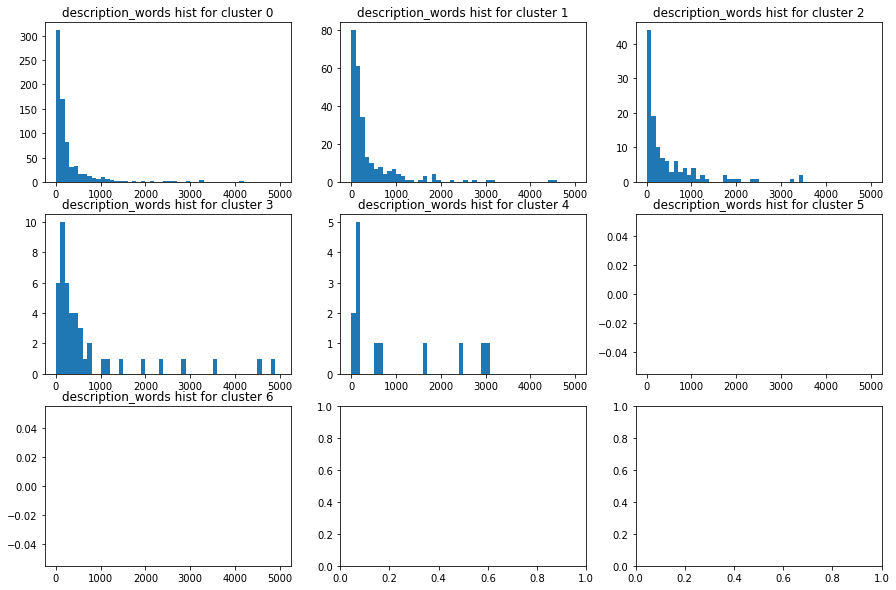

In [50]:
fig, axs = plt.subplots(3, 3, figsize=(15,10), )
ax = axs.flatten()
for i in range(7):
    ax[i].hist(df['total_sales'][df['cluster'] == i], bins=50, range=(0, 5_000))
    ax[i].set_title(f'{col} hist for cluster {i}')

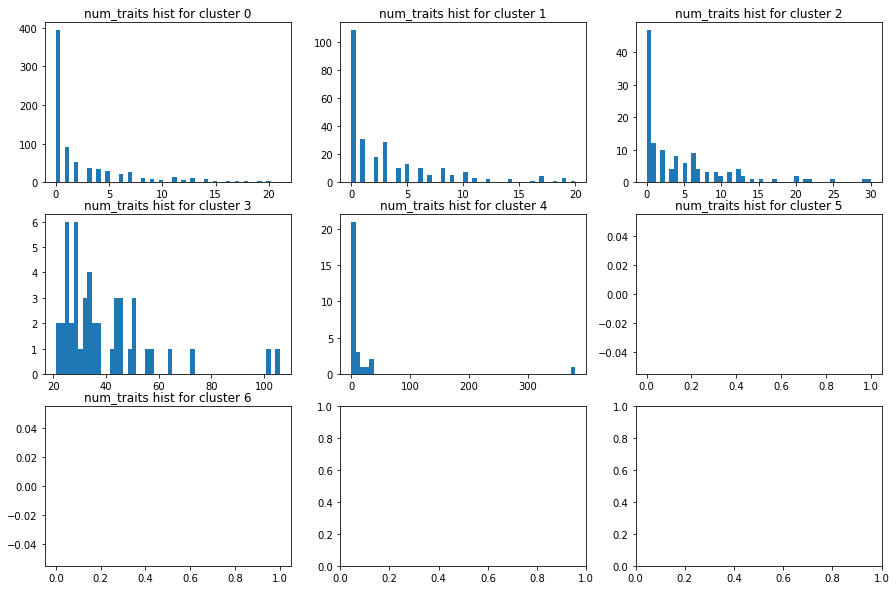

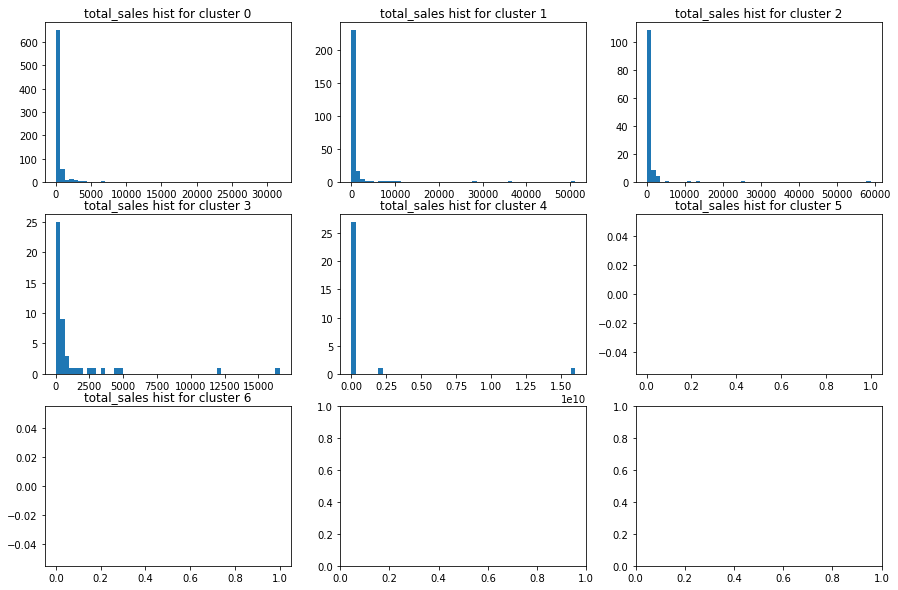

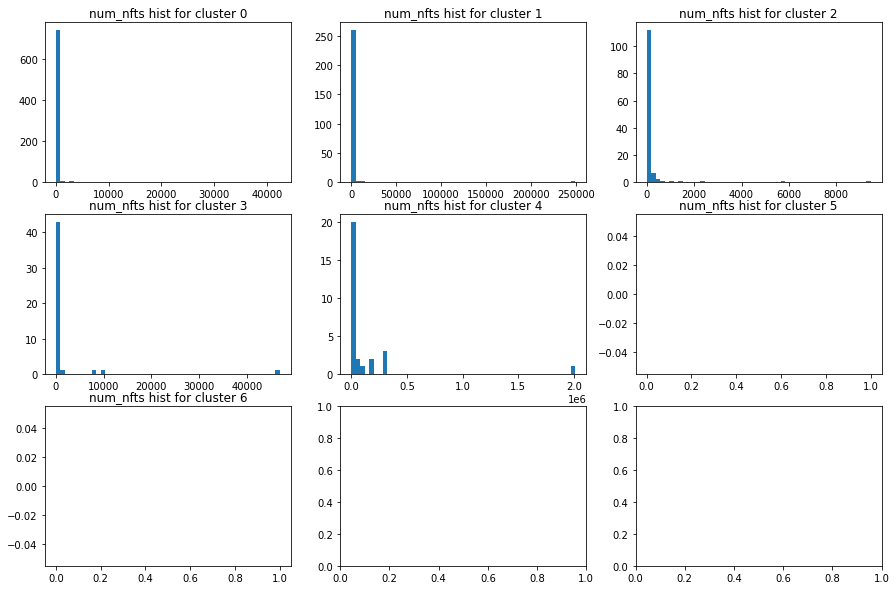

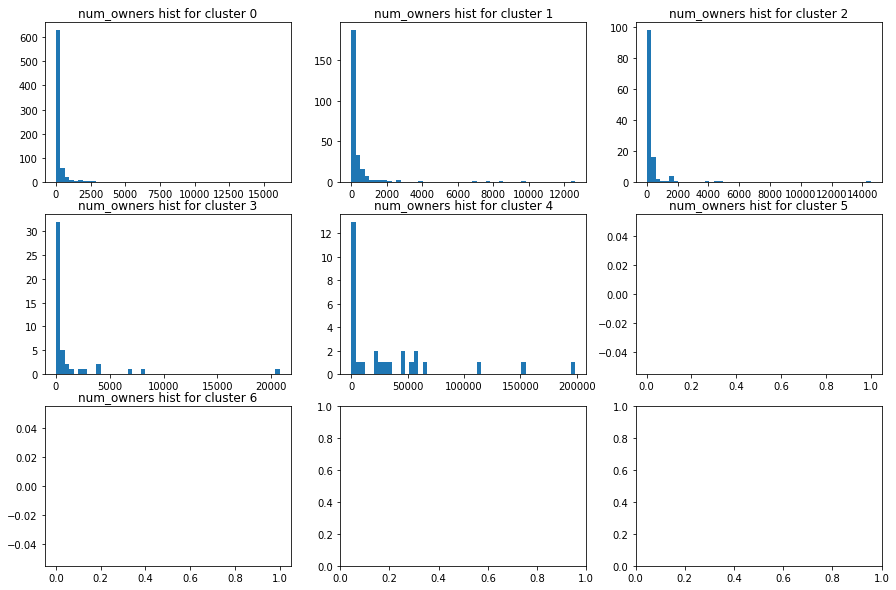

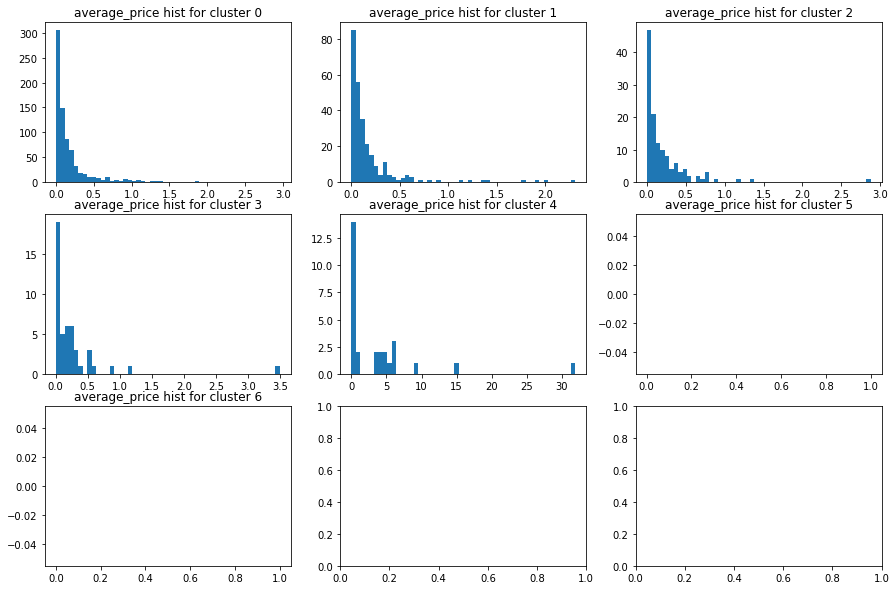

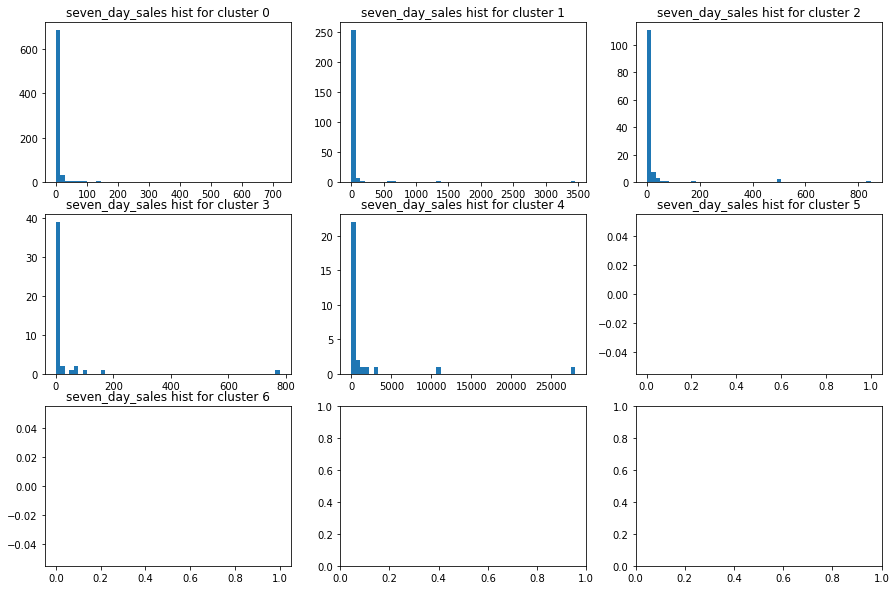

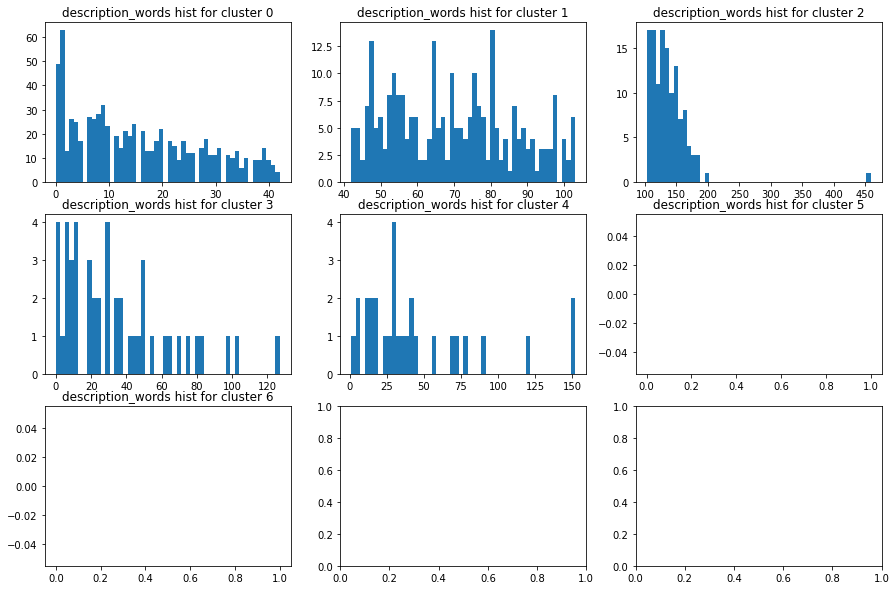

In [49]:
for col in means_cols:
    cluster_hists(col)